In [8]:
import mysql.connector
from typing import List
import matplotlib.pyplot as plt
import datetime

In [9]:
class DtoClampPoint:
    def __init__(self, C1ACRMS, C1TrueRMS, Time):
        self.C1ACRMS = C1ACRMS
        self.C1TrueRMS = C1TrueRMS
        self.Time = Time

class DtoPlugPoint:
    def __init__(self, Watt, Current, Voltage, Ip, Time):
        self.Watt = Watt
        self.Current = Current
        self.Voltage = Voltage
        self.Ip = Ip
        self.Time = Time

class TimeSeries:
    def __init__(self):
        self.Samples = []

class Sample:
    def __init__(self, CpuUtilization, ElapsedTime, AdditionalMetadata, 
                 DramEnergyInJoules, GpuEnergyInJoules, PackageTemperature, 
                 ProcessorPowerWatt, CpuEnergyInJoules):
        self.CpuUtilization = CpuUtilization
        self.ElapsedTime = ElapsedTime
        self.AdditionalMetadata = AdditionalMetadata
        self.DramEnergyInJoules = DramEnergyInJoules
        self.GpuEnergyInJoules = GpuEnergyInJoules
        self.PackageTemperature = PackageTemperature
        self.ProcessorPowerWatt = ProcessorPowerWatt
        self.CpuEnergyInJoules = CpuEnergyInJoules



In [10]:
def FetchClampResults(startTime: datetime, endTime: datetime) -> List[DtoClampPoint]:
    points = []
    config = {"host": "mysql47.unoeuro.com", "user": "stemlevelup_com", "password": "ez3rnBAx92p4", "database": "stemlevelup_com_db"}

    with mysql.connector.connect(**config) as connection:

        formattedStartTime = startTime.strftime("%Y-%m-%d %H:%M:%S.%f")
        formattedEndTime = endTime.strftime("%Y-%m-%d %H:%M:%S.%f")

        cursor = connection.cursor()
        query = "SELECT * FROM Measurements WHERE time BETWEEN %s AND %s"
        cursor.execute(query, (formattedStartTime, formattedEndTime))

        for (id,C1TrueRMS, C1ACRMS, time) in cursor:
            points.append(DtoClampPoint(C1ACRMS, C1TrueRMS, time))

        cursor.close()

        if len(points) == 0:
            raise ClampQueryFoundNoPointsException
    return points

def CalculateTimeSeries(startTime: datetime, endTime: datetime) -> TimeSeries:
    results = FetchClampResults(startTime,endTime)
    timeSeries = TimeSeries()
    elapsedMilliseconds = (endTime - startTime).total_seconds() * 1000
    avgRate = len(results) / (elapsedMilliseconds / 1000)

    for item in results:
        test = ConvertToJoule(item.C1TrueRMS , len(results))/avgRate
        timeSeries.Samples.append(Sample(
            CpuEnergyInJoules=test,
            ElapsedTime=(item.Time - startTime).total_seconds() * 1000,
            AdditionalMetadata={},
            CpuUtilization=0,
            DramEnergyInJoules=0,
            GpuEnergyInJoules=0,
            PackageTemperature=0,
            ProcessorPowerWatt=0
        ))

    return timeSeries

def ConvertToJoule(measurement: float, count: int) -> float:
    miliVolt = measurement * 1000 # Converts from volt to milliJoule
    A = miliVolt / 100 # Uses the specific conversion ratio
    joule = A * 230
    return joule


In [11]:
def FetchPlugResults(startTime: datetime, endTime: datetime) -> List[DtoPlugPoint]:
    points = []
    config = {"host": "mysql47.unoeuro.com", "user": "stemlevelup_com", "password": "ez3rnBAx92p4", "database": "stemlevelup_com_db"}

    with mysql.connector.connect(**config) as connection:
        formattedStartTime = startTime.strftime("%Y-%m-%d %H:%M:%S.%f")
        formattedEndTime = endTime.strftime("%Y-%m-%d %H:%M:%S.%f")

        cursor = connection.cursor()
        query = "SELECT * FROM power_usage WHERE time BETWEEN %s AND %s AND Ip = %s"
        cursor.execute(query, (formattedStartTime, formattedEndTime, "192.168.1.150"))

        for (id, Watt, Current, Voltage, Ip, time) in cursor:
            points.append(DtoPlugPoint(Watt, Current, Voltage, Ip, time))

        cursor.close()

        if len(points) == 0:
            raise PlugQueryFoundNoPointsException

    return points


def convert_watt_to_joule(watt, count, duration):
    avg_rate = count / (duration / 1000)
    return watt / avg_rate

def fetch_results(start_time, end_time):
    results = FetchPlugResults(start_time, end_time)
    elapsedMilliseconds = (end_time-start_time).total_seconds() * 1000
    time_series = TimeSeries()
    for item in results:
        time_series.Samples.append(Sample(
            CpuEnergyInJoules= convert_watt_to_joule(item.Watt, len(results), elapsedMilliseconds),
            ElapsedTime = (item.Time - start_time).total_seconds() * 1000,
            AdditionalMetadata={},
            CpuUtilization=0,
            DramEnergyInJoules=0,
            GpuEnergyInJoules=0,
            PackageTemperature=0,
            ProcessorPowerWatt=0,
            ))
    return time_series


2023-04-14 09:19:49.153094
2023-04-15 05:19:49.153094
34277
32754
32754
34277


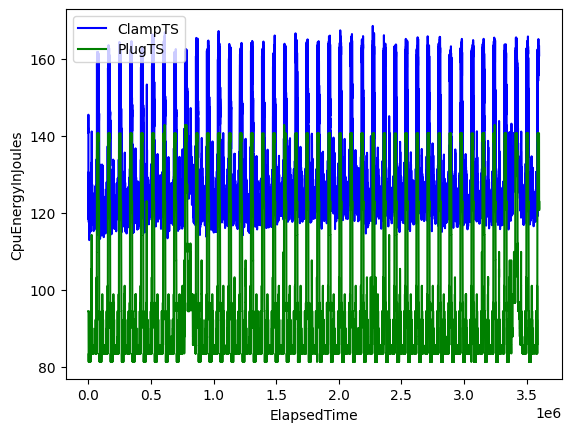

In [17]:

current_time = datetime.datetime.now()
format_string = "%Y-%m-%d %H:%M:%S.%f"
date_string = "2023-03-30 07:55:54.0" #plug
date_string = "2023-03-30 10:41:01.0" #clamp
start_time = current_time - datetime.timedelta(hours=3)
# end_time = current_time - datetime.timedelta(hours=15)
# start_time = datetime.datetime.strptime(date_string, format_string)
# start_time = start_time - datetime.timedelta(seconds=10)
end_time = start_time + datetime.timedelta(hours=20)
print(start_time)
print(end_time)
ClampTS =  CalculateTimeSeries(start_time,end_time)
PlugTS = fetch_results(start_time, end_time)
print(len(ClampTS.Samples))
print(len(PlugTS.Samples))
import matplotlib.pyplot as plt

# extract data for ClampTS
clamp_x = [s.ElapsedTime for s in ClampTS.Samples]
clamp_y = [s.CpuEnergyInJoules for s in ClampTS.Samples]

# extract data for PlugTS
plug_x = [s.ElapsedTime for s in PlugTS.Samples]
plug_y = [s.CpuEnergyInJoules for s in PlugTS.Samples]
print(len(plug_y))
print(len(clamp_y))

# plot the data
plt.plot(clamp_x, clamp_y, color='blue', label='ClampTS')
plt.plot(plug_x, plug_y, color='green', label='PlugTS')

# add axis labels and legend
plt.xlabel('ElapsedTime')
plt.ylabel('CpuEnergyInJoules')
plt.legend()

# show the plot
plt.show()

In [18]:
import numpy as np
ClampMean = []
PlugMean = []
stepSize = 1000
for i in range(0,len(clamp_y),stepSize):
    res = np.mean(clamp_y[i:i+stepSize])
    ClampMean.append(res)
for i in range(0,len(plug_y),stepSize):
    res = np.mean(plug_y[i:i+stepSize])
    PlugMean.append(res)